In [90]:
import numpy as mp 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [91]:
p = "C:/Users/princ/Downloads/Amazon Sale Report.csv/Amazon Sale Report.csv"
df = pd.read_csv(p, low_memory=False)

## Quick Checks

In [93]:
df.shape

(128975, 24)

In [94]:
df.columns

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')

In [95]:
df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [97]:
df.isnull().sum().sort_values(ascending=False).head(20)

fulfilled-by          89698
promotion-ids         49153
Unnamed: 22           49050
currency               7795
Amount                 7795
Courier Status         6872
ship-country             33
ship-postal-code         33
ship-state               33
ship-city                33
ship-service-level        0
Style                     0
Date                      0
B2B                       0
Status                    0
Fulfilment                0
Sales Channel             0
Qty                       0
Order ID                  0
ASIN                      0
dtype: int64

***#Drop garbage / almost-empty columns***

In [99]:
# drop Unnamed columns and any column that's mostly empty and not useful
cols_to_drop = []
if 'Unnamed: 22' in df.columns:
    cols_to_drop.append('Unnamed: 22')

# drop fulfilled-by because >50% missing and not necessary for core analysis
if 'fulfilled-by' in df.columns:
    pct_missing = df['fulfilled-by'].isnull().mean()
    if pct_missing > 0.5:
        cols_to_drop.append('fulfilled-by')

df = df.drop(columns=cols_to_drop)


***#Create promotion flag (promotion-ids ~38% missing)***

In [129]:
# treat missing promotion-id as "no promotion" but keep original col
df['is_promoted'] = df['promotion-ids'].notna() & df['promotion-ids'].astype(str).str.strip().ne('')

# for clarity, fill missing text with empty string (optional)
df['promotion-ids'] = df['promotion-ids'].fillna('')

***#Currency (6% missing) — infer or fill with mode***

In [103]:
# if dataset is single-country single-currency, fill with most common currency

if 'currency' in df.columns:
    mode_currency = df['currency'].mode().iloc[0]
    df['currency_imputed'] = df['currency'].isnull().astype(int)
    df['currency'] = df['currency'].fillna(mode_currency)


***#Amount (6% missing) — attempt to recompute then impute, and flag***

In [105]:
# flag before filling
df['Amount_missing_flag'] = df['Amount'].isnull().astype(int)

# try to recompute Amount using Qty * unit price (if unit price column exists)
if 'Price' in df.columns:
    df['Amount'] = df['Amount'].fillna(df['Qty'].fillna(1) * df['Price'])

# otherwise, fill by SKU median -> Category median -> overall median
if df['Amount'].isnull().any():
    if 'SKU' in df.columns:
        df['Amount'] = df['Amount'].fillna(df.groupby('SKU')['Amount'].transform('median'))
    if 'Category' in df.columns and df['Amount'].isnull().any():
        df['Amount'] = df['Amount'].fillna(df.groupby('Category')['Amount'].transform('median'))
    df['Amount'] = df['Amount'].fillna(df['Amount'].median())

# keep a column to show which amounts were imputed
df['Amount_was_imputed'] = df['Amount_missing_flag'] & df['Amount'].notnull()


***Courier Status (~5% missing) — fill and flag***

In [107]:
if 'Courier Status' in df.columns:
    df['CourierStatus_missing_flag'] = df['Courier Status'].isnull().astype(int)
    df['Courier Status'] = df['Courier Status'].fillna('Unknown')


***Small number of missing shipping fields (33 rows) — propagate or mark Unknown***

if 'Order ID' in df.columns:
    ship_cols = ['ship-city', 'ship-state', 'ship-postal-code', 'ship-country']
    for col in ship_cols:
        if col in df.columns:
            # make lookup dict from first non-null value
            lookup = df.dropna(subset=[col]).groupby('Order ID')[col].first().to_dict()
            df[col] = df['Order ID'].map(lookup).fillna(df[col])

# Fill leftovers with 'Unknown'
for col in ['ship-city', 'ship-state', 'ship-postal-code', 'ship-country']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')


***Date convert into datetime***

In [111]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

C:\Users\princ\AppData\Local\Temp\ipykernel_17516\2263964175.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   index                       128975 non-null  int64         
 1   Order ID                    128975 non-null  object        
 2   Date                        128975 non-null  datetime64[ns]
 3   Status                      128975 non-null  object        
 4   Fulfilment                  128975 non-null  object        
 5   Sales Channel               128975 non-null  object        
 6   ship-service-level          128975 non-null  object        
 7   Style                       128975 non-null  object        
 8   SKU                         128975 non-null  object        
 9   Category                    128975 non-null  object        
 10  Size                        128975 non-null  object        
 11  ASIN                        128975 non-

In [113]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.day_name()

In [114]:
for col in ['ship-country', 'ship-postal-code', 'ship-state', 'ship-city']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

In [115]:
print(df[['ship-country','ship-postal-code','ship-state','ship-city']].isnull().sum())


ship-country        0
ship-postal-code    0
ship-state          0
ship-city           0
dtype: int64


In [116]:
df.isnull().sum().sort_values(ascending=False)

index                         0
Order ID                      0
Month                         0
Year                          0
CourierStatus_missing_flag    0
Amount_was_imputed            0
Amount_missing_flag           0
currency_imputed              0
is_promoted                   0
B2B                           0
promotion-ids                 0
ship-country                  0
ship-postal-code              0
ship-state                    0
ship-city                     0
Amount                        0
currency                      0
Qty                           0
Courier Status                0
ASIN                          0
Size                          0
Category                      0
SKU                           0
Style                         0
ship-service-level            0
Sales Channel                 0
Fulfilment                    0
Status                        0
Date                          0
DayOfWeek                     0
dtype: int64

In [117]:
# Total sales value
if 'Amount' in df.columns:
    print("Total Sales Amount:", df['Amount'].sum())

Total Sales Amount: 83683166.6


In [118]:
# Top 10 selling products
if 'SKU' in df.columns:
    top_products = df.groupby('SKU')['Amount'].sum().sort_values(ascending=False).head(10)
    print("\nTop 10 Products:\n", top_products)


Top 10 Products:
 SKU
J0230-SKD-M        566619.20
JNE3797-KR-L       562066.77
J0230-SKD-S        506625.14
JNE3797-KR-M       480750.16
JNE3797-KR-S       432292.57
JNE3797-KR-XL      352735.24
J0230-SKD-L        330828.95
JNE3797-KR-XS      321256.70
SET268-KR-NP-S     296974.48
SET268-KR-NP-XL    295090.96
Name: Amount, dtype: float64


**#Time Series Trends**

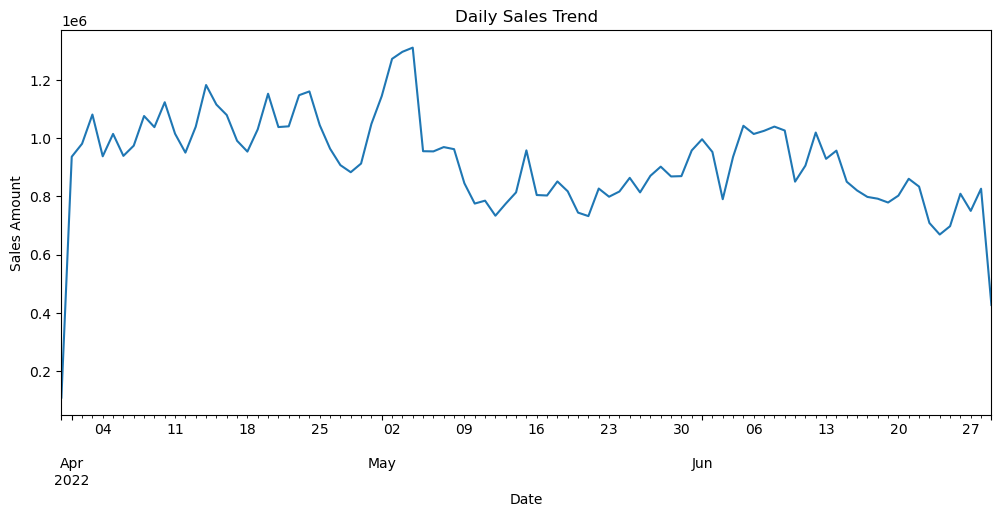

In [120]:
if 'Date' in df.columns and 'Amount' in df.columns:
    sales_trend = df.groupby('Date')['Amount'].sum()
    plt.figure(figsize=(12,5))
    sales_trend.plot()
    plt.title("Daily Sales Trend")
    plt.ylabel("Sales Amount")
    plt.xlabel("Date")
    plt.show()

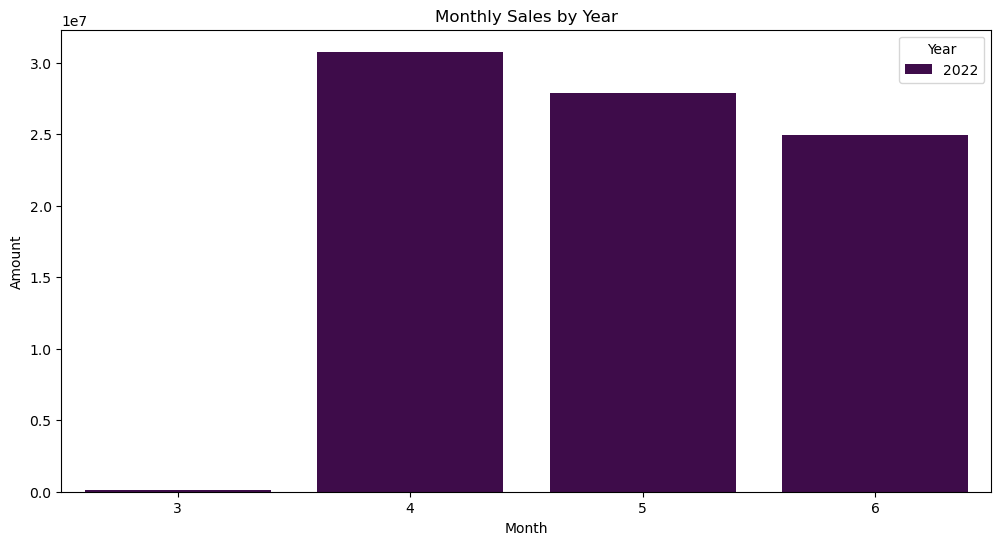

In [121]:
if 'Year' in df.columns and 'Month' in df.columns:
    monthly_sales = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    plt.figure(figsize=(12,6))
    sns.barplot(x='Month', y='Amount', hue='Year', data=monthly_sales, palette="viridis")
    plt.title("Monthly Sales by Year")
    plt.show()

C:\Users\princ\AppData\Local\Temp\ipykernel_17516\2022495551.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_sales.index, y=cat_sales.values, palette="coolwarm")


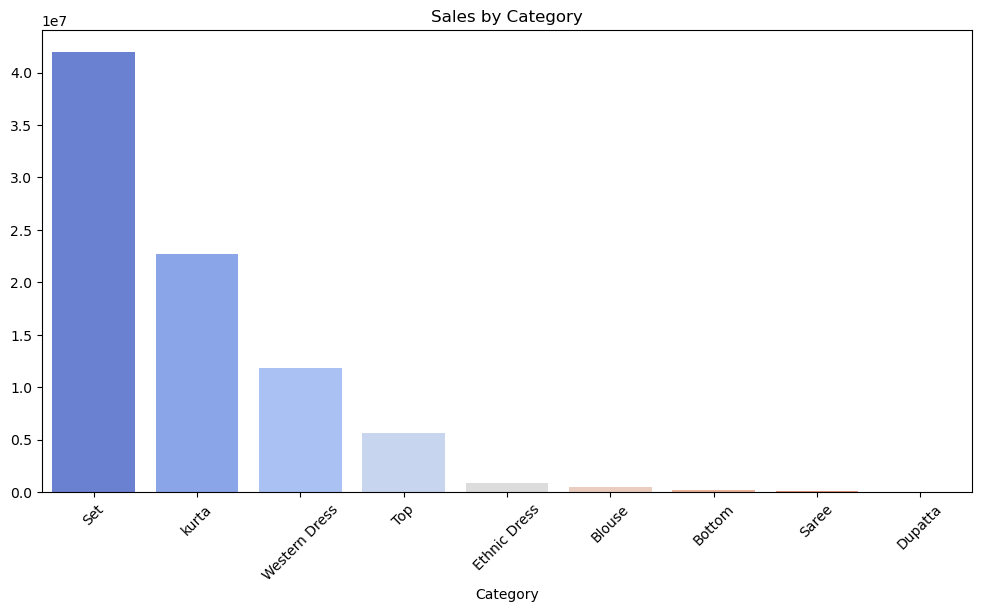

In [122]:
if 'Category' in df.columns:
    plt.figure(figsize=(12,6))
    cat_sales = df.groupby('Category')['Amount'].sum().sort_values(ascending=False)
    sns.barplot(x=cat_sales.index, y=cat_sales.values, palette="coolwarm")
    plt.title("Sales by Category")
    plt.xticks(rotation=45)
    plt.show()

C:\Users\princ\AppData\Local\Temp\ipykernel_17516\609064959.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_sales.index, y=state_sales.values, palette="mako")


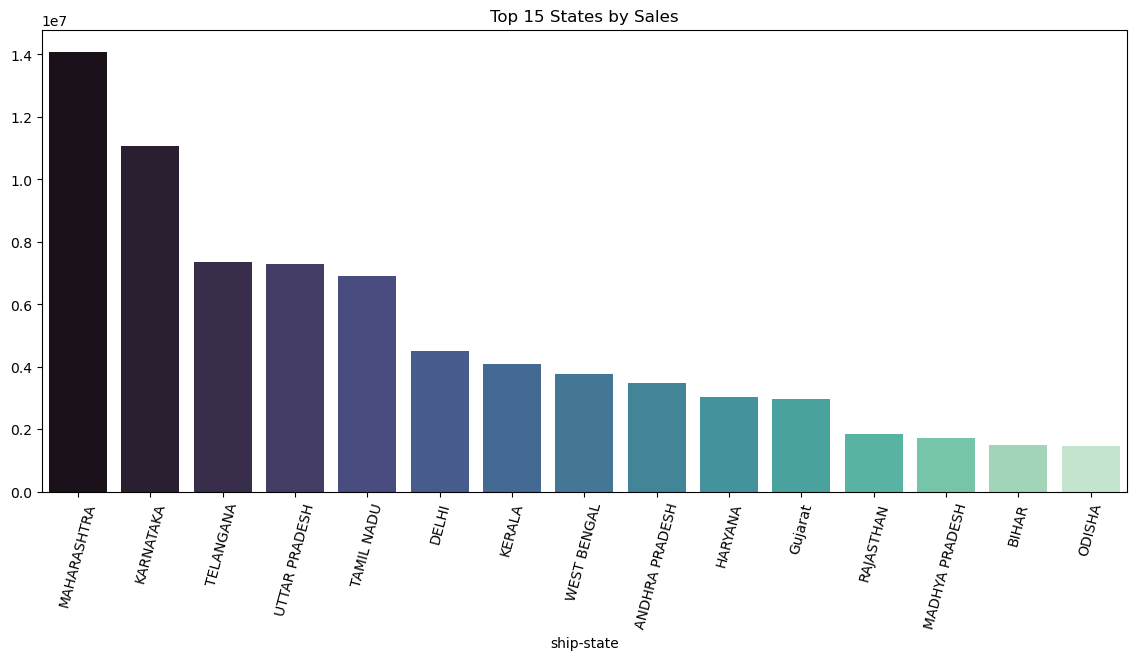

In [123]:
if 'ship-state' in df.columns:
    plt.figure(figsize=(14,6))
    state_sales = df.groupby('ship-state')['Amount'].sum().sort_values(ascending=False).head(15)
    sns.barplot(x=state_sales.index, y=state_sales.values, palette="mako")
    plt.title("Top 15 States by Sales")
    plt.xticks(rotation=75)
    plt.show()

In [124]:
if 'fulfilled-by' in df.columns:
    plt.figure(figsize=(8,5))
    fb_sales = df.groupby('fulfilled-by')['Amount'].sum().sort_values(ascending=False)
    sns.barplot(x=fb_sales.index, y=fb_sales.values, palette="Set2")
    plt.title("Sales by Fulfillment Type")
    plt.show()

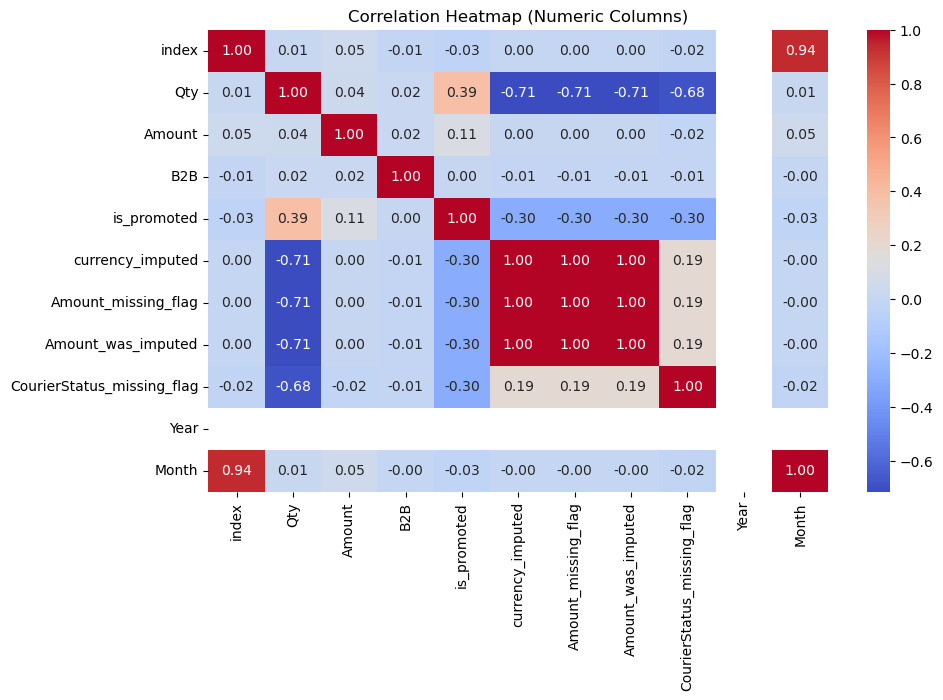

In [125]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Columns)")
plt.show()

In [127]:
# Save the cleaned dataset
df.to_csv("Amazon_Sales_Cleaned.csv", index=False )
